### Southern Greater Kudu Horn Size Analysis

Note to self:

Threshold:

- At least one horn has length of >54 inches

Analyse:

- Number of trophies by: year, country, hunter
- Size of trophies by: year, country, hunter
- Hunter with largest average trophies
- Hunter with longest career (min and max years / datediff)
- Put trophy into percentile in terms of size
- Check distribution across sizes for each country


### setup

In [1]:
# setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


### data overview

In [2]:
# load data previously scraped

df = pd.read_csv(r'/Users/stewarttaylor/Dev/Projects/rowland ward/rowlandward_data.csv')

df.head()

,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method
0,73 7/8,71 5/8,11,11,27 7/8,"Mozambique, Save R.",1963,Dr. Carlo Caldesi,Dr. Carlo Caldesi,PU
1,62 5/8,72 5/8,10 1/8,0,23 5/8,"Namibia, Hochfeld",2001,Johann Rohrer,Johann Rohrer,R
2,72 4/8,57 7/8,9 3/8,10 1/8,33,"RSA, Limpopo Prov., Hoedspruit",2010,Dewald Joubert,Dewald Joubert,R
3,66 2/8,69 2/8,11,0,40,"RSA, E. Transvaal",1916,James Cole Rous,James Cole Rous,R
4,68 7/8,68,11 4/8,11 3/8,22 7/8,"RSA, Mpumalanga, Marble Hall",1998,Nico Coetzee,Nico Coetzee,R


In [3]:
df.describe()

,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method
count,1991,1961,1990,1961,1991,1991,1991,1991,1991,1991
unique,114,139,49,45,323,558,81,1861,1862,3
top,54,0,11,0,0,"RSA, Limpopo Prov., Thabazimbi",2007,Mark Kretzschmar,Mark Kretzschmar,R
freq,96,371,231,375,56,69,113,6,6,1943


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   L-left         1991 non-null   object
 1   L-right        1961 non-null   object
 2   C-left         1990 non-null   object
 3   C-right        1961 non-null   object
 4   T to T         1991 non-null   object
 5   Locality       1991 non-null   object
 6   Date           1991 non-null   object
 7   Hunter/Owner   1991 non-null   object
 8   Current Owner  1991 non-null   object
 9   Method         1991 non-null   object
dtypes: object(10)
memory usage: 155.7+ KB


### cleaning

In [5]:
# Locality data doesn't let me aggregate by country in the current format

locality_counts = df['Locality'].value_counts()

locality_counts

RSA, Limpopo Prov., Thabazimbi      69
RSA                                 64
RSA, Limpopo Prov., Alldays         56
RSA, NW Prov., Zeerust              46
RSA, Limpopo Prov., Ellisras        44
                                    ..
Zimbabwe, Mashonaland, Centenary     1
Zimbabwe, Gweru                      1
RSA, Limpopo Prov, Thabazimbi        1
Malawi, Kachuta                      1
RSA, Mpumalanga, Potchefstroom       1
Name: Locality, Length: 558, dtype: int64

In [6]:
# add a new column for country

def extract_country(Locality):
    pattern_search = {
        r'(RSA|South Africa|Pungwe)': 'South Africa',
        r'(Zimbabwe|Zambezi|Zimabwe)': 'Zimbabwe',
        r'(Malawi)': 'Malawi',
        r'(Namibia|Ombujombindi)': 'Namibia',
        r'(Botswana|Bostwana|Boswana)': 'Botswana',
        r'(Mozambique)': 'Mozambique',
        r'(Zambia)': 'Zambia',
        r'(Swaziland)': 'Swaziland',
        r'(Angola)': 'Angola'
    }
    for pattern, country in pattern_search.items():
        if re.search(pattern, Locality, re.IGNORECASE):
            return country
    
    return 'Unknown'

df['Country'] = df['Locality'].apply(extract_country)

country_check = df['Country'].value_counts()

country_check

# I kept checking the unknown values and adding more items to pattern_search until all records had a country:
# unknown_coutries = df[df['Country'] == 'Unknown']
# unknown_coutries

South Africa    1616
Namibia          142
Zimbabwe         114
Zambia            39
Botswana          35
Mozambique        20
Malawi            11
Angola             8
Swaziland          6
Name: Country, dtype: int64

In [7]:
# length values are in fractional inches. Let's convert to decimal inches

l_horn_counts = df['L-left'].value_counts()

l_horn_counts

54        96
54 4/8    79
55        72
56        68
54 2/8    68
          ..
68 2/8     1
68 3/8     1
68 7/8     1
72 4/8     1
16 2/8     1
Name: L-left, Length: 114, dtype: int64

In [8]:
# come back to this

def to_decimal_inches(value):
    if pd.isna(value):  # Handle NaN
        return None
    
    # Regex pattern: matches whole number (optional fraction with numerator/denominator)
    pattern = r'(\d+)\s*(\d*/\d*)?'
    
    # Search for matches
    match = re.match(pattern, str(value).strip())
    if not match:
        return None  # Return None if no match (e.g., invalid format)
    
    whole = float(match.group(1))  # First group is the whole number
    fraction = match.group(2)      # Second group is the fraction (e.g., "4/8"), if present
    
    if fraction:
        num, denom = map(int, fraction.split('/'))  # Split fraction into numerator and denominator
        decimal = num / denom                       # Calculate decimal value
        return whole + decimal                      # Add to whole number
    return whole  # If no fraction, return whole number as float (e.g., 54.0)

# Apply the function to the 'L-left' column
df['L-left_decimal'] = df['L-left'].apply(to_decimal_inches)
df['L-right_decimal'] = df['L-right'].apply(to_decimal_inches)
df['C-left_decimal'] = df['C-left'].apply(to_decimal_inches)
df['C-right_decimal'] = df['C-right'].apply(to_decimal_inches)
df['T_to_T_decimal'] = df['T to T'].apply(to_decimal_inches)

# Display the result
df

,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method,Country,L-left_decimal,L-right_decimal,C-left_decimal,C-right_decimal,T_to_T_decimal
0,73 7/8,71 5/8,11,11,27 7/8,"Mozambique, Save R.",1963,Dr. Carlo Caldesi,Dr. Carlo Caldesi,PU,Mozambique,73.875,71.625,11.000,11.000,27.875
1,62 5/8,72 5/8,10 1/8,0,23 5/8,"Namibia, Hochfeld",2001,Johann Rohrer,Johann Rohrer,R,Namibia,62.625,72.625,10.125,0.000,23.625
2,72 4/8,57 7/8,9 3/8,10 1/8,33,"RSA, Limpopo Prov., Hoedspruit",2010,Dewald Joubert,Dewald Joubert,R,South Africa,72.500,57.875,9.375,10.125,33.000
3,66 2/8,69 2/8,11,0,40,"RSA, E. Transvaal",1916,James Cole Rous,James Cole Rous,R,South Africa,66.250,69.250,11.000,0.000,40.000
4,68 7/8,68,11 4/8,11 3/8,22 7/8,"RSA, Mpumalanga, Marble Hall",1998,Nico Coetzee,Nico Coetzee,R,South Africa,68.875,68.000,11.500,11.375,22.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,54,53 4/8,9 4/8,9 3/8,49 4/8,"RSA, NW Prov., Zeerust",1997,Johan van Niekerk,Johan van Niekerk,R,South Africa,54.000,53.500,9.500,9.375,49.500
1987,54,53,9 4/8,9 5/8,30,"RSA, NW Prov., Vryburg",2001,Fanie Kruger,Fanie Kruger,R,South Africa,54.000,53.000,9.500,9.625,30.000
1988,54,53 5/8,9 4/8,9 4/8,18,"RSA, Limpopo Prov., Alldays",2015,Skip Scheepers,Skip Scheepers,R,South Africa,54.000,53.625,9.500,9.500,18.000
1989,54,53 2/8,5 7/8,5 5/8,12,"RSA, Limpopo Prov., Alldays",2011,J. Gouws,J. Gouws,R,South Africa,54.000,53.250,5.875,5.625,12.000


In [9]:
# still need to find out what these horn measuring methods are and the impact they have

method_count = df['Method'].value_counts()

method_count

R     1943
PU      35
B       13
Name: Method, dtype: int64

In [10]:
# average horn length

df['avg_horn_length'] = (df['L-left_decimal'] + df['L-right_decimal']) / 2
  
df.head()


,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method,Country,L-left_decimal,L-right_decimal,C-left_decimal,C-right_decimal,T_to_T_decimal,avg_horn_length
0,73 7/8,71 5/8,11,11,27 7/8,"Mozambique, Save R.",1963,Dr. Carlo Caldesi,Dr. Carlo Caldesi,PU,Mozambique,73.875,71.625,11.000,11.000,27.875,72.7500
1,62 5/8,72 5/8,10 1/8,0,23 5/8,"Namibia, Hochfeld",2001,Johann Rohrer,Johann Rohrer,R,Namibia,62.625,72.625,10.125,0.000,23.625,67.6250
2,72 4/8,57 7/8,9 3/8,10 1/8,33,"RSA, Limpopo Prov., Hoedspruit",2010,Dewald Joubert,Dewald Joubert,R,South Africa,72.500,57.875,9.375,10.125,33.000,65.1875
3,66 2/8,69 2/8,11,0,40,"RSA, E. Transvaal",1916,James Cole Rous,James Cole Rous,R,South Africa,66.250,69.250,11.000,0.000,40.000,67.7500
4,68 7/8,68,11 4/8,11 3/8,22 7/8,"RSA, Mpumalanga, Marble Hall",1998,Nico Coetzee,Nico Coetzee,R,South Africa,68.875,68.000,11.500,11.375,22.875,68.4375


In [11]:
# longest horn

df['longest_horn'] = df[['L-left_decimal', 'L-right_decimal']].max(axis=1)

df.head()

,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method,Country,L-left_decimal,L-right_decimal,C-left_decimal,C-right_decimal,T_to_T_decimal,avg_horn_length,longest_horn
0,73 7/8,71 5/8,11,11,27 7/8,"Mozambique, Save R.",1963,Dr. Carlo Caldesi,Dr. Carlo Caldesi,PU,Mozambique,73.875,71.625,11.000,11.000,27.875,72.7500,73.875
1,62 5/8,72 5/8,10 1/8,0,23 5/8,"Namibia, Hochfeld",2001,Johann Rohrer,Johann Rohrer,R,Namibia,62.625,72.625,10.125,0.000,23.625,67.6250,72.625
2,72 4/8,57 7/8,9 3/8,10 1/8,33,"RSA, Limpopo Prov., Hoedspruit",2010,Dewald Joubert,Dewald Joubert,R,South Africa,72.500,57.875,9.375,10.125,33.000,65.1875,72.500
3,66 2/8,69 2/8,11,0,40,"RSA, E. Transvaal",1916,James Cole Rous,James Cole Rous,R,South Africa,66.250,69.250,11.000,0.000,40.000,67.7500,69.250
4,68 7/8,68,11 4/8,11 3/8,22 7/8,"RSA, Mpumalanga, Marble Hall",1998,Nico Coetzee,Nico Coetzee,R,South Africa,68.875,68.000,11.500,11.375,22.875,68.4375,68.875


In [12]:
# Get a rough area of each set of horns by treating like a triangle

def horn_area(a, b, c):
    a = float(a)
    b = float(b)
    c = float(c)
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

df['triangle_area'] = df.apply(lambda row: horn_area(row['L-left_decimal'], row['L-right_decimal'], row['T_to_T_decimal']),axis=1)

df['triangle_area'] = df['triangle_area'].round(3)

df.head()

/var/folders/js/6pkplm2d2w57pddzd59s9n0c0000gn/T/ipykernel_23994/1840842277.py:8: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


,L-left,L-right,C-left,C-right,T to T,Locality,Date,Hunter/Owner,Current Owner,Method,Country,L-left_decimal,L-right_decimal,C-left_decimal,C-right_decimal,T_to_T_decimal,avg_horn_length,longest_horn,triangle_area
0,73 7/8,71 5/8,11,11,27 7/8,"Mozambique, Save R.",1963,Dr. Carlo Caldesi,Dr. Carlo Caldesi,PU,Mozambique,73.875,71.625,11.000,11.000,27.875,72.7500,73.875,991.924
1,62 5/8,72 5/8,10 1/8,0,23 5/8,"Namibia, Hochfeld",2001,Johann Rohrer,Johann Rohrer,R,Namibia,62.625,72.625,10.125,0.000,23.625,67.6250,72.625,712.603
2,72 4/8,57 7/8,9 3/8,10 1/8,33,"RSA, Limpopo Prov., Hoedspruit",2010,Dewald Joubert,Dewald Joubert,R,South Africa,72.500,57.875,9.375,10.125,33.000,65.1875,72.500,932.798
3,66 2/8,69 2/8,11,0,40,"RSA, E. Transvaal",1916,James Cole Rous,James Cole Rous,R,South Africa,66.250,69.250,11.000,0.000,40.000,67.7500,69.250,1290.968
4,68 7/8,68,11 4/8,11 3/8,22 7/8,"RSA, Mpumalanga, Marble Hall",1998,Nico Coetzee,Nico Coetzee,R,South Africa,68.875,68.000,11.500,11.375,22.875,68.4375,68.875,771.180


In [13]:
# see why some rows are invalid:

invalid_rows = df[df['triangle_area'].isna()]

print(invalid_rows[['L-left_decimal', 'L-right_decimal', 'T_to_T_decimal', 'triangle_area']])


      L-left_decimal  L-right_decimal  T_to_T_decimal  triangle_area
8             68.000            0.000          12.500            NaN
13            67.000           66.375           0.000            NaN
14            66.625            0.000          39.125            NaN
16            66.500            0.000          40.500            NaN
17            66.250            0.000          26.000            NaN
...              ...              ...             ...            ...
1969          54.000            0.000          33.500            NaN
1971          54.000           53.625           0.000            NaN
1972          54.000            0.000          19.500            NaN
1973          54.000            0.000          31.750            NaN
1980          54.000            0.000          40.000            NaN

[451 rows x 4 columns]


In [14]:
# check NaN values

nan_check = df.isna().sum()

nan_check

L-left               0
L-right             30
C-left               1
C-right             30
T to T               0
Locality             0
Date                 0
Hunter/Owner         0
Current Owner        0
Method               0
Country              0
L-left_decimal       0
L-right_decimal     30
C-left_decimal       1
C-right_decimal     30
T_to_T_decimal       2
avg_horn_length     30
longest_horn         0
triangle_area      451
dtype: int64

In [15]:
# clean up NaN values

columns_to_update = ['L-right_decimal', 'C-left_decimal', 'C-right_decimal', 'T_to_T_decimal']

for column in columns_to_update:
    df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0.000)

print(df[columns_to_update].isna().sum())

L-right_decimal    0
C-left_decimal     0
C-right_decimal    0
T_to_T_decimal     0
dtype: int64


In [16]:
# categorise trophies based on complete measurments

left = pd.to_numeric(df['L-left_decimal'], errors='coerce').fillna(0.000)
right = pd.to_numeric(df['L-right_decimal'], errors='coerce').fillna(0.000)
tip = pd.to_numeric(df['T_to_T_decimal'], errors='coerce').fillna(0.000)

conditions = [
    (left == 0) | (right == 0),
    tip == 0,
    ((left != 0) & (right != 0) & (tip != 0))
    ]

outputs = ['single', 'no_tips', 'complete']

df['completness'] = np.select(conditions, outputs, default='unknown')

print(df['completness'].value_counts())


complete    1541
single       402
no_tips       48
Name: completness, dtype: int64


In [17]:
# remove columns 

df_cleaned = df.drop(columns=['L-left', 'L-right', 'C-left', 'C-right','C-left_decimal', 'C-right_decimal', 'T to T', 'Locality', 'Current Owner', 'Method'])

df_cleaned

,Date,Hunter/Owner,Country,L-left_decimal,L-right_decimal,T_to_T_decimal,avg_horn_length,longest_horn,triangle_area,completness
0,1963,Dr. Carlo Caldesi,Mozambique,73.875,71.625,27.875,72.7500,73.875,991.924,complete
1,2001,Johann Rohrer,Namibia,62.625,72.625,23.625,67.6250,72.625,712.603,complete
2,2010,Dewald Joubert,South Africa,72.500,57.875,33.000,65.1875,72.500,932.798,complete
3,1916,James Cole Rous,South Africa,66.250,69.250,40.000,67.7500,69.250,1290.968,complete
4,1998,Nico Coetzee,South Africa,68.875,68.000,22.875,68.4375,68.875,771.180,complete
...,...,...,...,...,...,...,...,...,...,...
1986,1997,Johan van Niekerk,South Africa,54.000,53.500,49.500,53.7500,54.000,1180.829,complete
1987,2001,Fanie Kruger,South Africa,54.000,53.000,30.000,53.5000,54.000,769.884,complete
1988,2015,Skip Scheepers,South Africa,54.000,53.625,18.000,53.8125,54.000,477.387,complete
1989,2011,J. Gouws,South Africa,54.000,53.250,12.000,53.6250,54.000,319.105,complete


### eda

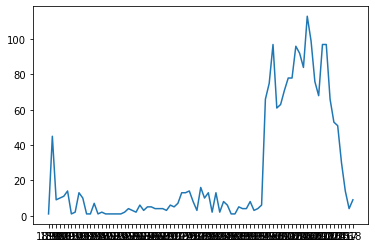

In [18]:
# check records by year

year_counts = df['Date'].value_counts().sort_index()

sns.lineplot(x = year_counts.index, y = year_counts.values)

plt.show()

In [19]:
# top 10 hunters/owners

hunter_counts = df['Hunter/Owner'].value_counts()

hunter_counts.head(10)

Mark Kretzschmar     6
Chris Steenberg      5
Renier Bouwer        4
Willem van Rooyen    4
Arnold Jonker        4
John Bacon           4
Angus Murray         4
D.G. Grobler         4
A. Joannou           4
F.C. Selous          3
Name: Hunter/Owner, dtype: int64